# Notebook to perform evaluation procedure as described in "*Multispecies detection and identification of African mammals in aerial imagery using CNN*"


---

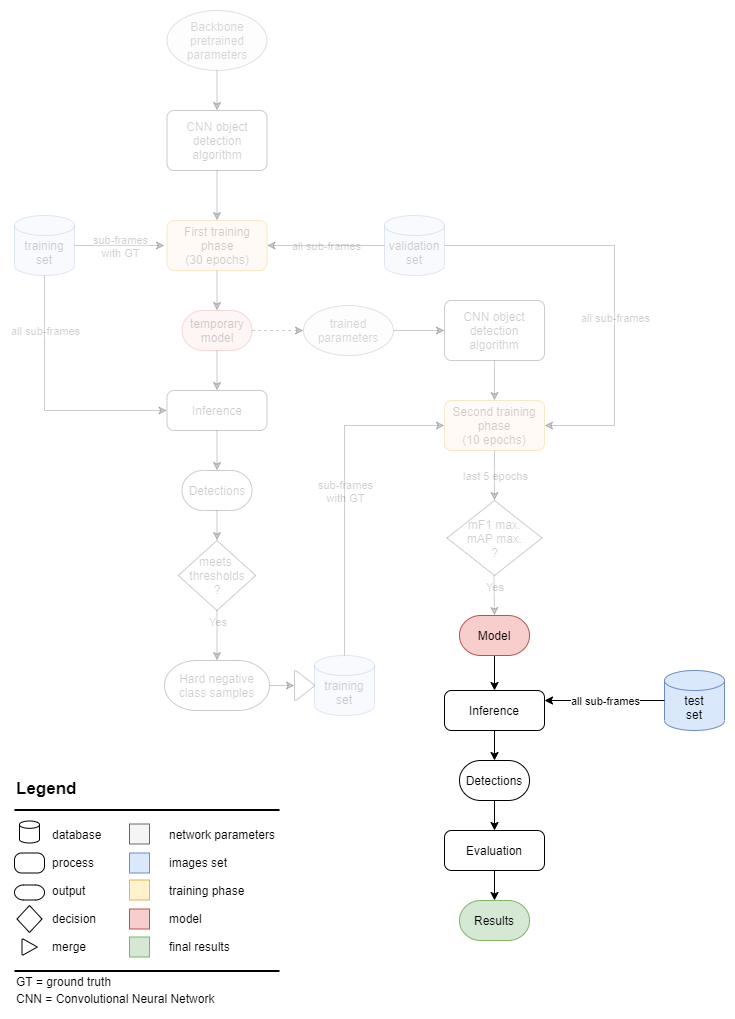



# GPU
You must need a GPU of 16GB for inference with sub-frames of 2,000x2,000 pixels !

In [ ]:
import torch

# GPU
t = torch.cuda.get_device_properties(0).total_memory
t_GB = t/float((1024**3))
name = torch.cuda.get_device_name()
print('[GPU] Name : {:s} | Memory : {:.2f} GB'.format(name,t_GB))

# Mount to your Drive
Note that annotations and images must be in your drive.

In [ ]:
# Connection to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Installations
You first need to import the mmdetection folder into your drive.
At the end of the installations, you will need to restart runtime, just click on the suggested button. Then, go the next section and run the cells.

In [ ]:
import os
from os.path import exists, join, basename, splitext
import shutil
import sys
import torch

# MMDetection directory (local)
mmdetection_dir = '/content/drive/My Drive/mmdetection'
print("MMdetection path : {}".format(mmdetection_dir))

# Installations of dependencies
!pip install parse
!pip install torch==1.4.0 torchvision==0.5.0
!pip install -q mmcv==0.6.0 terminaltables

# Installation of MMDetection
!cd {mmdetection_dir} && python setup.py install
!pip install -r "/content/drive/My Drive/mmdetection/requirements.txt"

# Path to system
sys.path.append(mmdetection_dir)

# Test

In [ ]:
# Develop MMDetection
mmdetection_dir = '/content/drive/My Drive/mmdetection'
%cd {mmdetection_dir}
!python setup.py develop

## Useful functions

In [ ]:
import os
from PIL import Image
from albumentations import Compose, BboxParams, Crop
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
import json
import time
import datetime
from datetime import date
import csv
from os.path import exists, join, basename, splitext
from mmdet.apis import inference_detector, init_detector
import collections
import pandas as pd
from sklearn.metrics import confusion_matrix
from collections import Counter
import shutil

class Subframes(object):
    ''' 
    Class allowing the visualisation and the cropping of a labeled 
    image (bbox) into sub-frames whose dimensions are specified 
    by the user.

    Attributes
    -----------
    img_name : str
        name of the image (with extension, e.g. "My_image.JPG").
    image : PIL
        PIL image.
    target : dict
        Must have 'boxes' and 'labels' keys at least.
        'boxes' must be a list in the 'coco' bounding box format :
        [[xmin, ymin, width, height], ...]
    width : int
        width of the sub-frames
    height : int
        height of the sub-frames
    strict : bool
        set to True get sub-frames of exact same size 
        (e.g width x height) (default: False)
    
    Methods
    --------
    getlist(overlap=False)
        Produces a results list containing, for each row :
        the sub-frame (3D list, dtype=uint8), the bboxes (2D list),
        the labels (1D list) and the filename (str).
    visualise(results)
        Displays ordered sub-frames of the entire image.
    topoints(results)
        Converts the bounding boxes into points annotations.
    displayobjects(results, points_results, ann_type='point')
        Displays only sub-frames containing objects.
    save(results, output_path, object_only=True)
        Saves sub-frames to a specific path.
    '''

    def __init__(self, img_name, image, target, width, height, strict=False):
        '''
        Parameters
        -----------
        img_name : str
            name of the image (with extension, e.g. "My_image.JPG")
        image : PIL
            PIL image
        target : dict
            Must have 'boxes' and 'labels' keys at least.
        width : int
            width of the sub-frames
        height : int
            height of the sub-frames
        strict : bool
            set to True get sub-frames of exact same size 
            (e.g width x height) (default: False)
        '''

        self.img_name = img_name
        self.image = image
        self.target = target
        self.width = width
        self.height = height
        self.strict = strict

        self.img_width = image.size[0]
        self.img_height = image.size[1]

        self.x_sub = 1 + int((self.img_width - (self.img_width % width)) / width)
        self.y_sub = 1 + int((self.img_height - (self.img_height % height)) / height)

    def getlist(self, overlap=False):
        '''
        Produces a results list containing, for each row :
        the sub-frame (3D list, dtype=uint8), the bboxes (2D list),
        the labels (1D list) and the filename (str).
        Parameters
        -----------
        overlap : bool, optional
            Set to True to get an overlap of 50% between 
            2 sub-frames (default: False)
        Returns
        --------
        list
        '''
        height = self.height
        width = self.width
        img_height = self.img_height
        img_width = self.img_width

        results = []

        # Image preprocessing      
        image_np = np.array(self.image)
        boxes = self.target['boxes']
        labels = self.target['labels']
        annotations = {'image':image_np,'bboxes':boxes,'labels':labels}

        # Crop lists
        if overlap is True:
            overlap = 0.5
            y_sub = int(np.round(height*overlap))
            x_sub = int(np.round(width*overlap))
            rg_ymax = img_height-y_sub
            rg_xmax = img_width-x_sub
        else:
            y_sub = height
            x_sub = width
            rg_ymax = img_height
            rg_xmax = img_width

        crops = []

        for y in range(0, rg_ymax, y_sub):
            if  y+height <= img_height:
                for x in range(0, rg_xmax, x_sub):
                    if  x+width <= img_width:
                        xmin, ymin = x, y
                        xmax, ymax = x+width, y+height
                    elif x+img_width%width <= img_width:
                        xmin, ymin = img_width - width, y
                        xmax, ymax = x+img_width%width, y+height

                    if self.strict is True:
                        crops.append([xmin, ymin, xmax, ymax])
                    else:
                        crops.append([x, y, xmax, ymax])
            
            elif  y+img_height%height <= img_height:
                for x in range(0, rg_xmax, x_sub):
                    if  x+width <= img_width:
                        xmin, ymin = x, img_height - height
                        xmax, ymax = x+width, y+img_height%height
                    elif x+img_width%width <= img_width:
                        xmin, ymin = img_width - width, img_height - height
                        xmax, ymax = x+img_width%width, y+img_height%height

                    if self.strict is True:
                        crops.append([xmin, ymin, xmax, ymax])
                    else:
                        crops.append([x, y, xmax, ymax])

        sub = 0
        for xmin, ymin, xmax, ymax in crops:
            transf = Compose([Crop(xmin, ymin, xmax, ymax, p=1.0)], 
                                bbox_params=BboxParams(format='coco',
                                                        min_visibility=0.25, 
                                                        label_fields=['labels']))
            augmented  = transf(**annotations)
            sub_name = self.img_name.rsplit('.')[0] + "_S" + str(sub) + ".JPG"
            results.append([augmented['image'],augmented['bboxes'],augmented['labels'],sub_name])
            sub += 1

        return results

    def visualise(self, results):
        '''
        Displays ordered sub-frames of the entire image.
        Parameters
        -----------
        results : list
            The list obtained by the method getlist().
        Returns
        --------
        matplotlib plot
        '''

        if len(results) > (self.x_sub*self.y_sub):
            x_sub = 2*self.x_sub - 2
            y_sub = 2*self.y_sub - 2
        else:
            x_sub = self.x_sub
            y_sub = self.y_sub

        plt.figure(1)
        plt.suptitle(self.img_name)
        sub = 1
        for line in range(len(results)):

            if self.img_width % self.width != 0:
                n_col = x_sub
                n_row = y_sub
            else:
                n_col = x_sub - 1
                n_row = y_sub - 1

            plt.subplot(n_row, n_col, sub, xlim=(0,self.width), ylim=(self.height,0))
            plt.imshow(Image.fromarray(results[line][0]))
            plt.axis('off')
            plt.subplots_adjust(wspace=0.1,hspace=0.1)

            text_x = np.shape(results[line][0])[1]
            text_y = np.shape(results[line][0])[0]

            if self.width > self.height:
                f = self.height*(self.y_sub/y_sub)
            else:
                f = self.width*(self.x_sub/x_sub)

            plt.text(0.5*text_x, 0.5*text_y, 
                    "S"+str(line),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=0.02*f,
                    color='w')
            sub += 1

    def topoints(self, results):
        '''
        Converts the bounding boxes into points annotations.
        Parameters
        -----------
        results : list
            The list obtained by the method getlist().
        Returns
        --------
        list
            A 2D list with headers : "id", "filename", "count",
            "locations" where
            - "id" represents the unique id of the sub-frame within 
              the image
            - "filename" is the name of the sub-frame 
              (e.g. "My_image_S1.JPG")
            - "count" is the number of objects into the sub-frame
            - "points" is a list of tuple representing the 
              locations of the objects (y,x)
    
        '''

        points_results = [['id','filename','count','locations']]
        loc = []
        for line in range(len(results)):
            # Verify that bbox exists
            if results[line][1]:
                count = len(results[line][1])
                for bbox in range(len(results[line][1])):
                    boxe = results[line][1][bbox]
                    x = int(boxe[0]+(boxe[2])/2)
                    y = int(boxe[1]+(boxe[3])/2)
                    point = (y,x)
                    loc.append(point)
            
                sub_name = self.img_name.rsplit('.')[0] + "_S" + str(line) + ".JPG"
                points_results.append([line, sub_name, count, loc])
                loc = []

        return points_results

    def displayobjects(self, results, points_results, ann_type='point'):
        '''
        Displays only sub-frames containing objects.
        Parameters
        -----------
        results : list
            The list obtained by the method getlist().
        points_results : list
            The list obtained by the method topoints(results).
        ann_type : str, optional
            A string used to specify the annotation type. Choose
            between :
            - 'point' to visualise points
            - 'bbox' to visualise bounding boxes
            - 'both' to visualise both
            (default is 'point')
        Returns
        --------
        matplotlib plot
        '''

        sub_r = 0
        sub_c = 0

        n_row = int(np.round(math.sqrt(len(points_results)-1)))
        n_col = n_row

        if int(len(points_results)-1) > int(n_row*n_col):
            n_row += 1

        fig, ax = plt.subplots(nrows=n_row, ncols=n_col, squeeze=False)

        for r in range(n_row):
            for c in range(n_col):
                ax[r,c].axis('off')
                plt.subplots_adjust(wspace=0.1,hspace=0.1)

        for o in range(1,len(points_results)):

            id_object = points_results[o][0]
            patch_object = results[id_object][0]

            text_x = np.shape(results[id_object][0])[1]
            text_y = np.shape(results[id_object][0])[0]

            # Plot
            ax[sub_r,sub_c].imshow(Image.fromarray(patch_object))
            ax[sub_r,sub_c].text(0.5*text_x, 0.5*text_y, 
                    "S"+str(id_object),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=15,
                    color='w',
                    alpha=0.6)

            if ann_type == 'point':
                points = points_results[o][3]
                for p in range(len(points)):
                    ax[sub_r,sub_c].scatter(points[p][1],points[p][0], color='r')
            
            elif ann_type == 'bbox':
                bboxes = results[id_object][1]
                for b in range(len(bboxes)):
                    rect = patches.Rectangle((bboxes[b][0],bboxes[b][1]),bboxes[b][2],bboxes[b][3], linewidth=1, edgecolor='r', facecolor='none')
                    ax[sub_r,sub_c].add_patch(rect)
                
            elif ann_type == 'both':
                points = points_results[o][3]
                bboxes = results[id_object][1]
                for b in range(len(bboxes)):
                    ax[sub_r,sub_c].scatter(points[b][1],points[b][0], color='b')
                    rect = patches.Rectangle((bboxes[b][0],bboxes[b][1]),bboxes[b][2],bboxes[b][3], linewidth=1, edgecolor='r', facecolor='none')
                    ax[sub_r,sub_c].add_patch(rect)

            else:
                raise ValueError('Annotation of type \'{}\' unsupported. Choose between \'point\',\'bbox\' or \'both\'.'.format(ann_type))
                
            if sub_c < n_col-1:
                sub_r = sub_r
                sub_c += 1
            else:
                sub_c = 0
                sub_r += 1
            
    def save(self, results, output_path, object_only=True):
        '''
        Saves sub-frames (.JPG) to a specific path.
        Parameters
        -----------
        results : list
            The list obtained by the method getlist().
        output_path : str
            The path to the folder chosen to save sub-frames.
        object_only : bool, optional
            A flag used to choose between :
            - saving all the sub-frames of the entire image
              (set to False)
            - saving only sub-frames with objects
              (set to True, default)
        Returns
        --------
        None
        '''

        for line in range(len(results)):
            if object_only is True:
                if results[line][1]:
                    subframe = Image.fromarray(results[line][0])
                    sub_name =  results[line][3]
                    subframe.save(os.path.join(output_path, sub_name))
                    
            elif object_only is not True:
                subframe = Image.fromarray(results[line][0])
                sub_name =  results[line][3]
                subframe.save(os.path.join(output_path, sub_name))

def softnms(preds, Nt, tresh, method='linear', sigma=0.5):
    '''
    Function for applying the Non-Maximum Suppression 
    (NMS) filter and Soft-NMS.

    Parameters
    ----------
    preds : dict
        Contains, at least, 3 keys:
          - 'boxes' : list, containing a list of 
            predicted bounding boxes,
          - 'labels' : int, containing a list of labels
            associated to the bboxes,
          - 'scores' : float, containing confidence 
            scores associated to predictions.
    
    Nt : float
        IoU treshold to apply.

    tresh : float
        Scores treshold.
    
    method : str, optional
        Choose between:
          - 'nms' for classical non-soft NMS
          - 'linear' for linear Soft-NMS
          - 'gaussian' for gaussian Soft-NMS

        In this third case, it is possible to
        specify the variance, by changing 'sigma'.

        Default: 'linear'
    
    sigma : float, optional
        Variance of gaussian's curve.

        Default: 0.5


    Returns
    -------
    dict
        Contains the 3 initial keys including filtered
        values.

    Notes
    -----
    Based on:
      - https://github.com/DocF/Soft-NMS/blob/master/soft_nms.py
      - https://github.com/bharatsingh430/soft-nms/blob/master/lib/nms/cpu_nms.pyx

    '''

    boxes = np.array(preds['boxes'])
    labels = np.array(preds['labels'])
    scores = np.array(preds['scores'])

    boxes_f = boxes.copy()
    labels_f = labels.copy()
    scores_f = scores.copy()

    if len(boxes)==0:
        return []

    if boxes.dtype.kind == "i":
		    boxes = boxes.astype("float")

    N = boxes.shape[0]
    ind = np.array([np.arange(N)])
    boxes = np.concatenate((boxes, ind.T), axis=1)

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):

        # temporary variables
        t_boxes = boxes[i, :].copy()
        t_score = scores[i].copy()
        t_area = areas[i].copy()
        pos = i + 1

        if i != N-1:
            max_score = np.max(scores[pos:], axis=0)
            max_pos = np.argmax(scores[pos:], axis=0)

        else:
            max_score = scores[-1]
            max_pos = 0

        if t_score < max_score:
            boxes[i, :] = boxes[max_pos + i + 1, :]
            boxes[max_pos + i + 1, :] = t_boxes
            t_boxes = boxes[i,:]

            scores[i] = scores[max_pos + i + 1]
            scores[max_pos + i + 1] = t_score
            t_score = scores[i]

            areas[i] = areas[max_pos + i + 1]
            areas[max_pos + i + 1] = t_area
            t_area = areas[i]

        # compute IoU
        xx1 = np.maximum(boxes[i, 0], boxes[pos:, 0])
        yy1 = np.maximum(boxes[i, 1], boxes[pos:, 1])
        xx2 = np.minimum(boxes[i, 2], boxes[pos:, 2])
        yy2 = np.minimum(boxes[i, 3], boxes[pos:, 3])


        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        # IoU
        iou = (w * h) / (areas[i] + areas[pos:] - (w * h))

        # Weigthing
        # ---
        # 1 - Linear
        if method == 'linear':
            weight = np.ones(iou.shape)
            weight[iou > Nt] = weight[iou > Nt] - iou[iou > Nt]
        # 2 - Gaussian
        elif method == 'gaussian':
            weight = np.exp(-(iou*iou)/sigma)
        # 3 - Original
        elif method == 'nms':
            weight = np.ones(iou.shape)
            weight[iou > Nt] = 0

        scores[pos:] = weight * scores[pos:]
  
    idx = boxes[:,4][scores > tresh]
    pick = idx.astype(int)

    return {'boxes':boxes_f[pick],'labels':labels_f[pick],'scores':scores_f[pick]}

def overlap_merging(img_path, coco_path, width, height, output_path, 
                    mmdet_model, nms_method='nms', IoU=0.3, sc_tresh=0.5):
    '''
    Function to perform inference and stitching of the 
    resulting predictions on a big-sized image cut into 
    sub-frames with 50% overlap, in order to obtain the 
    original image and its predictions.

    To be used with the Subframes class.

    Parameters
    ----------
    img_path : str
        Path to the image.

    coco_path : str
        Path to the COCO-annotation type (JSON).
    
    width : int
        Width of the sub-frames.

    height : int
        Height of the sub-frames.
    
    output_path : str
        Sub-frames saving path.
    
    mmdet_model : object
        Model built from mmdet.apis.init_detector

    nms_method : str, optional
        NMS method to apply to bounding boxes.
        Choose between:
            - 'nms' : for classic NMS
            - 'linear' : for linear soft-NMS
            - 'gaussian' : for gaussian soft-NMS (sigma=0.5)
        Default : 'nms'

    IoU : float, optional
        (Soft-)NMS treshold.
        Default : 0.3
    
    sc_tresh : float, optional
        Scores treshold to applay on predictions.
        Default : 0.5

    Returns
    -------
    dict
        Resulting predictions containing 3 keys:
          - 'boxes' (2D array)
          - 'labels' (1D array)
          - 'scores' (1D array)
    '''

    t_i = time.time()

    with open(coco_path,'r') as json_file:
        coco_dic = json.load(json_file)

    cls_names = []
    for cls in coco_dic['categories']:
        cls_names.append(cls['name'])

    # PIL image
    pil_img = Image.open(img_path)

    # Infos
    name = basename(img_path)

    w_sub = int(pil_img.width/width)
    h_sub = int(pil_img.height/height)

    if pil_img.width % width != 0:
        w_sub += 1
    if pil_img.height % height != 0:
        h_sub += 1


    # Export folder
    save_path = os.path.join(output_path,name)
    if os.path.exists(save_path) is not True:
        os.mkdir(save_path)

    # Get annos
    for image in coco_dic['images']:
        if image['file_name'] == name:
            img_id = image['id']

    boxes = []
    labels = []
    for ann in coco_dic['annotations']:
        if ann['image_id'] == img_id:
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])

    gt = {'boxes':boxes, 'labels':labels}

    # Subframes class instantiation
    sub_img = Subframes(name, pil_img, gt, width, height)

    # overlap
    results = sub_img.getlist(overlap=True)

    sub_img.save(results, save_path, object_only=False)

    os.chdir(save_path)
    files = os.listdir(save_path)
    files.sort(key=os.path.getctime)

    files_2D = np.reshape(np.array(files), (2*h_sub-1,2*w_sub-1))

    # Initializations
    w_offset = 0
    h_offset = 0
    global_boxes = []
    global_labels = []
    global_scores = []

    for y in range(files_2D.shape[0]):
        for x in range(files_2D.shape[1]):

            # Image
            image = files_2D[y,x]

            # Predictions
            predictions = inference_detector(mmdet_model, image)

            # adapt
            boxes = []
            labels = []
            scores = []
            for n_class in range(len(cls_names)):
                for n_box in range(len(predictions[n_class])):
                    box = list(predictions[n_class][n_box][:4])
                    score = predictions[n_class][n_box][4]
                    boxes.append(box)
                    labels.append(n_class+1)
                    scores.append(score)

            predictions = {'boxes': boxes, 'labels': labels, 'scores': scores}

            # Put into a global frame
            i = 0
            for box in predictions['boxes']:

                new_box = [box[0] + w_offset,
                          box[1] + h_offset,
                          box[2] + w_offset,
                          box[3] + h_offset]            
                
                global_boxes.append(new_box)
                global_labels.append(predictions['labels'][i])
                global_scores.append(predictions['scores'][i])

                i += 1

            w_offset += 0.5*width

        w_offset = 0
        h_offset += 0.5*height

    global_preds = {
        'boxes':global_boxes, 
        'labels':global_labels,
        'scores':global_scores
        }

    # Soft-NMS 
    global_preds = softnms(global_preds, IoU, sc_tresh, method=nms_method)

    t_f = time.time()

    shutil.rmtree(save_path)

    return global_preds

class ModelPerformances(object):
    '''
    Class to obtain the performances of an object detection model 
    based on 2 csv files: the groundtruth and the detections.

    The groundtruth file must contain a header of :
    | 'Image' | 'x1' | 'y1' | 'x2' | 'y2' | 'Label' |

    The detections file must contain a header of :
    | 'Image' | 'x1' | 'y1' | 'x2' | 'y2' | 'Label' | 'Score' |

    Note that the labels must obviously correspond between the 
    groundtruth and the detections.

    ...

    Attributes
    ----------
    gt_path : str
        Path to the groundtruth CSV file
    det_path : str
        Path to the detection CSV file
    gt : DataFrame
        DataFrame from the groundtruth CSV file
    det : DataFrame
        DataFrame from the detection CSV file
    IoU : float
        IoU threshold
    match : DataFrame
        DataFrame created by 'compare' property. Contains comparison
        between detections and groundtruth
    seen_objects : dict
        Dictionnary with image name as keys and list as value.
        In list, 0 means object not seen (no match with a detection),
        and 1 seen
    
    Properties
    ----------
    compare
        Compare detections and ground truth
    pr_table
        Get table with, among others things, precision and recall
        values for each confidence score
    confusion_matrix
        Compute confusion matrix
    results_table
        Get table with performances of each category (precision, recall,
        F1-scores, confusion between categories, FP/TP ratio, Average
        Precision)
    mAP
        Compute the mean Average Precision (mAP)
    binary
        Get table with performances of the model as it was a binary case
        object vs background (precision, recall, F1-scores, FP/TP ratio)
    max_f1
        Find maximum F1-scores and corresponding precision, recall
        and score

    '''

    def __init__(self, gt, det, IoU):
        '''
        Parameters
        ----------
        gt : str
            Path to the groundtruth CSV file
        det : str
            Path to the detection CSV file
        IoU : float
            IoU threshold
        '''

        # Paths attributes
        self.gt_path = gt
        self.det_path = det

        # Open files
        self.gt = pd.read_csv(gt)
        self.det = pd.read_csv(det)

        self.IoU = IoU

        self.match = self.compare

    # Private methods
    # ---
    def __compute_IoU(self, box_A, box_B):
        '''
        Method to compute Intersect-over-Union (IoU)
        between two lists of boxes.

        Parameters
        ----------
        box_A : list
            (dim=4) 2 points-style (upper-left (x1,y1) and 
            bottom-right (x2,y2))

        box_B : list
            (dim=4) 2 points-style (upper-left (x1,y1) and 
            bottom-right (x2,y2))
        
        Returns
        -------
        IoU : float
        '''

        # Détermination des coord. (x,y) de l'intersection	
        xA = max(box_A[0],box_B[0])	
        yA = max(box_A[1],box_B[1])	
        xB = min(box_A[2],box_B[2])	
        yB = min(box_A[3],box_B[3])	

        # Aire de cette intersection	
        area = max(0, xB - xA +1) * max(0, yB - yA +1)	

        # Aires de la box A et de la box B	
        area_A = (box_A[2] - box_A[0] + 1) * (box_A[3] - box_A[1] + 1)	
        area_B = (box_B[2] - box_B[0] + 1) * (box_B[3] - box_B[1] + 1)	

        # Calcul de l'IoU	
        IoU = area / float(area_A + area_B - area)	

        return IoU

    def __AP(self, rec, prec):
        '''
        Method to compute the VOC Average Precision.

        Code from: https://github.com/Cartucho/mAP
        (adapted from official matlab code VOC2012)

        Parameters
        ----------
        rec : list
            Recall increasing values.
        prec : list
            Precision decreasing values.

        Returns
        -------
        Average Precision : float
        
        '''
        rec.insert(0, 0.0)
        rec.append(1.0)
        mrec = rec[:]
        prec.insert(0, 0.0) 
        prec.append(0.0) 
        mpre = prec[:]

        for i in range(len(mpre)-2, -1, -1):
            mpre[i] = max(mpre[i], mpre[i+1])

        i_list = []
        for i in range(1, len(mrec)):
            if mrec[i] != mrec[i-1]:
                i_list.append(i) 

        ap = 0.0
        for i in i_list:
            ap += ((mrec[i]-mrec[i-1])*mpre[i])

        return ap
 
    # Properties
    # ---
    @property
    def compare(self):
        '''
        Compare detections and ground truth.

        Returns
        -------
        pd.DataFrame
            With additionals columns : 
            - 'Assignment' which contains 'TP' or 'FP';
            - 'IoU';
            - 'GT' : with groundtruth's labels;
        '''

        ground = self.gt.values.tolist()
        preds = self.det.values.tolist()
        IoU_t = self.IoU

        # Initialize columns
        idx = 0
        for pred in preds:
            pred.append(0) # GT (7)
            pred.append('') # Assignment (8)
            pred.append(0.0) # IoU (9)
            pred.append(idx) # idx (10)
            idx += 1

        # Get categories
        cat_gt = [int(row[5]) for row in ground]
        cat_p = [int(row[5]) for row in preds
                          if math.isnan(row[5]) is not True]
        cat = list(set(cat_gt + cat_p))
        
        # Create dictionary with amount of gts for each image
        seen_det = Counter([gt[0] for gt in ground])
        for key, val in seen_det.items():
            seen_det[key] = np.zeros(val)

        # Loop through categories
        for c in cat:

            # Get predictions
            preds_c = [p for p in preds if p[5]==c]
            # Sort by decreasing confidence score
            preds_c.sort(key=lambda x:x[6], reverse=True)

            # Loop through predictions
            for p in preds_c:

                # Get index of initial detections
                index = p[10]

                # Find corresponding ground truth
                gt = [gt for gt in ground if p[0] in gt[0]]

                # Initialize IoU and gt max
                iou_max = 0.0

                # Loop through ground truth
                for j , g in zip(range(len(gt)),gt):

                    # Compute IoU
                    gt_box , p_box = g[1:5] , p[1:5]
                    iou = self.__compute_IoU(gt_box,p_box)

                    if iou > iou_max:
                        iou_max = iou
                        j_max = j
                        gt_max = g[5]

                # Prediction assignment
                if iou_max >= IoU_t:

                    if seen_det[p[0]][j_max] == 0:

                        if gt_max==c:
                            # Assignment
                            preds[index][8] = 'TP'
                            # GT label
                            preds[index][7] = gt_max

                        else:
                            # Assignment
                            preds[index][8] = 'FP'
                            # GT label
                            preds[index][7] = gt_max

                        # Set 'Seen' flag to 1
                        seen_det[p[0]][j_max] = 1

                    else:
                        preds[index][8] = 'FP'

                else:
                    preds[index][8] = 'FP'
                
                # IoU
                preds[index][9] = iou_max

        # Create a dataframe with the list of lists
        header = ['Image','x1','y1','x2','y2','Label','Score','GT','Assignment','IoU','id']
        match = pd.DataFrame(data=preds, columns=header)

        # Attribute "seen_objects" 
        self.seen_objects = seen_det

        return match[['Image','x1','y1','x2','y2','Label','Score','GT','IoU','Assignment']]

    @property
    def pr_table(self):
        '''
        To get table with, among others things, precision and recall
        values for each confidence score.

        Returns
        -------
        pandas.DataFrame or dict
            Dataframe if only one category, otherwise dict with categories
            as keys and Dataframe as values
        '''

        # Get matching between gt and detections
        # To list to save time
        match_df = self.match.values.tolist()

        # List of categories
        categories = list(set(self.gt['Label']))

        # Loop through categories
        all_cat = {}
        for cat in categories:

            # Initialize a list
            res_df = []

            # Get matches
            cat_df = [m for m in match_df if m[5]==cat]
            # Sort by decreasing confidence score
            cat_df.sort(key=lambda x:x[6], reverse=True)

            # Groundtruth
            n_gt = len(self.gt[self.gt['Label']==cat])

            # Initialize variable
            cum_tp = 0
            cum_fp = 0

            # Fill in with matching results
            for row in cat_df:

                # Compute cumulative TP and FP
                if row[9]=='TP':
                    tp , fp = 1 , 0
                    cum_tp += 1
                else:
                    tp , fp = 0 , 1
                    cum_fp += 1

                # Add to list
                res_df.append(
                    [
                        row[5],
                        row[6],
                        tp,
                        fp,
                        cum_tp,
                        cum_fp,
                        cum_tp/(cum_tp+cum_fp),
                        cum_tp/n_gt
                    ]
                )
            
            # Transform list to DataFrame
            header = ['Detection','Score','TP','FP','Cum_TP','Cum_FP','Precision','Recall']
            res_df = pd.DataFrame(data=res_df, columns=header)

            all_cat.update({cat : res_df})

        if len(all_cat)==1:
            out_df = res_df
        else:
            out_df = all_cat

        return out_df

    @property
    def confusion_matrix(self):
        '''
        Compute confusion matrix.

        Returns
        -------
        2D list
        '''

        # Get data
        match_df = self.match
        all_gt = list(match_df['GT'])
        all_det = list(match_df['Label'])

        # Use Sklearn's confusion matrix
        categories = list(set(list(set(all_gt)) + list(set(all_det))))
        categories = [int(c) for c in categories]
        matrix = confusion_matrix(all_gt, all_det, labels=categories)
        matrix = pd.DataFrame(data=matrix, columns=categories, index=categories)

        # Add false negatives
        for cat in categories[1:]:
            matrix.at[cat,0] = len(self.gt[self.gt['Label']==cat]) - sum(matrix.loc[cat])

        return matrix
    
    @property
    def results_table(self):
        '''
        Get table with performances of each category (precision, recall,
        F1-scores, confusion between categories, FP/TP ratio, Average
        Precision)

        Returns
        -------
        pandas.DataFrame
        '''

        # Call confusion_matrix method
        cm = self.confusion_matrix.values.tolist()

        # Initialization
        mean_f1 = 0
        df = []

        # Compute precision, recall, F1-score, confusion
        for row , cat in zip(cm[1:], range(1,len(cm))):
            tp = cm[cat][cat]
            fn = sum([c for c in cm[cat]]) - tp
            fp = sum([c[cat] for c in cm]) - tp
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
            confusion = 1 - (row[cat]/(sum(row)-row[0]))

            if precision > 0 and recall > 0:
              f1_score = 2*precision*recall/(precision+recall)
              mean_f1 += f1_score
            else:
              f1_score = 0
              mean_f1 += f1_score
            
            # Append to DataFrame
            if tp == 0:
              fp_tp = 'inf'
            else:
              fp_tp = fp/tp

            df.append(
                [
                  cat,
                  precision,
                  recall,
                  f1_score,
                  fp_tp,
                  confusion,
                  0.0
                ]              
            )

        mean_f1 = mean_f1/len(cm)

        # Get data for AP
        tables  = self.pr_table

        # Loop through data
        for i,key in zip(range(len(tables)),tables):

            # Precision and recall lists
            precision = list(tables[key]['Precision'])
            recall = list(tables[key]['Recall'])

            # Compute AP
            ap = self.__AP(recall,precision)

            df[i][6] = ap

        # Transform list to DataFrame
        header = ['Category','Precision','Recall','F1-score','FP/TP','Confusion','AP']
        df = pd.DataFrame(data=df, columns=header)

        return df
    
    @property
    def mAP(self):
        '''
        Compute the mean Average Precision (mAP).
        
        Returns
        -------
        float
        '''

        # Get data
        tables = self.pr_table

        # Loup through categories
        ap_list = []
        for key in tables:

            # Precision and recall lists
            precision = list(tables[key]['Precision'])
            recall = list(tables[key]['Recall'])

            # Compute AP
            ap = self.__AP(recall,precision)
            ap_list.append(ap)
        
        # Compute mean of APs
        m_ap = np.mean(ap_list)

        return m_ap
    
    @property
    def binary(self):
        '''
        Get table with performances of the model as it was a binary case
        object vs background (precision, recall, F1-scores, FP/TP ratio)

        Returns
        -------
        pandas.DataFrame
        '''

        # Call confusion matrix method
        cm = self.confusion_matrix.values.tolist()

        # Compute TP, FP, FN as a binary case
        tp = sum([sum(c[1:]) for c in cm[1:]])
        gt = sum([sum(c) for c in cm[1:]])
        fp = sum(cm[0])

        # Compute Precision, Recall
        precision = tp/(tp+fp)
        recall = tp/gt

        # Store into a DataFrame
        df = pd.DataFrame(
            data = {
                'Precision': [precision],
                'Recall': [recall],
                'F1-score': [2*precision*recall/(precision+recall)],
                'FP/TP': [fp/tp]
            }
        )
        
        return df
   
    @property
    def max_f1(self):
        '''
        Find maximum F1-scores and corresponding precision, recall
        and score.

        Returns
        -------
        pandas.DataFrame
        '''

        # Get data
        tables = self.pr_table

        # Initialize a list
        df = []

        # Loop through tables
        for cat , tab in tables.items():
            # Get precision and recall
            precision = list(tab['Precision'])
            recall = list(tab['Recall'])

            # Compute F1-scores for each row
            f1_scores = []
            for pr, re in zip(precision, recall):
                # Avoid divid by 0
                if (pr + re) != 0:
                    f1_score = 2 * pr * re / (pr + re)
                else:
                    f1_score = 0
                
                f1_scores.append(f1_score)
            
            # Find the maximum
            f1_score_max = max(f1_scores)
            idx = f1_scores.index(f1_score_max)

            # Append to list
            df.append([
                  cat,
                  f1_score_max,
                  tab.loc[idx,'Score'], 
                  tab.loc[idx,'Precision'], 
                  tab.loc[idx,'Recall'], 
            ])
        
        # Transform list to DataFrame
        header = ['Category','F1-score','Score','Precision','Recall']
        df = pd.DataFrame(data = df, columns = header)

        return df


## Detections

### Fill with your paths
Warning, 'checkpoint' key now refers to **best epoch model** determined during validation.

Note also that the config file must refer to the one with the hard negative class !

In [ ]:
# Images
images_folder = '< path to your TEST images folder >'

# Annotations
original_size_annos = '< path to your original size TEST images annotations (.json) >'
original_size_csv_annos = '< path to your original size TEST images annotations (.csv) >'

# Models
models = {
    'faster_rcnn' : {
        'config_hnc' : '< path to the config file with hard negative class >',
        'checkpoint' : '< path to the BEST checkpoint FILE >',
        'out' : '< path to your outputs folder >'
    },
    'libra_rcnn' : {
        'config_hnc' : '< path to the config file with hard negative class >',
        'checkpoint' : '< path to the BEST checkpoint FILE >',
        'out' : '< path to your outputs folder >'
    },
    'retinanet' : {
        'config_hnc' : '< path to the config file with hard negative class >',
        'checkpoint' : '< path to the BEST checkpoint FILE >',
        'out' : '< path to your outputs folder >'
    }
}

# Seed
seed = 'ENTER YOUR SEED VALUE HERE'

### Select the model

In [ ]:
# Which model ? Fill with the dictionnary name
# ---
model_name = 'faster_rcnn'
# ---

### Get detections for each best model

In [ ]:
import pandas as pd
from mmdet.apis import init_detector
import time
import datetime
from datetime import date
import numpy as np
import os

# Initialize the model
model = init_detector(models[model_name]['config_hnc'], models[model_name]['checkpoint'])

# Initialize DataFrame
df = pd.DataFrame(columns=['Image','x1','y1','x2','y2','Label','Score'])

# Get images
images = os.listdir(images_folder)
if os.path.exists('/content/images_sub') is False:
    os.mkdir('/content/images_sub')

# Start inference on images
t_start = time.time()
for i,image in zip(range(len(images)),images):
    t_i = time.time()

    # Get predictions
    results = overlap_merging(
        img_path=os.path.join(images_folder,image),
        coco_path=original_size_annos,
        width=2000,
        height=2000,
        output_path='/content/images_sub',
        mmdet_model=model,
        IoU=0.5,
        sc_tresh=0.0
    )

    t_f = time.time()

    # Infos
    elapsed = str(datetime.timedelta(seconds=int(np.round(t_f-t_i))))
    print('Image [{}/{}] | Name : {} | Elapsed time : {}'
          .format(str(i+1), len(images), image, elapsed))

    if bool(results):
        for box , label , score in zip(results['boxes'],results['labels'],results['scores']):
            df = df.append(
                {'Image':image,
                'x1':box[0],
                'y1':box[1],
                'x2':box[2],
                'y2':box[3],
                'Label':label,
                'Score':score},
                ignore_index=True
            )
    # If no predictions, add a blank row
    else:
        df = df.append(
            {'Image':image,
            'x1':None,
            'y1':None,
            'x2':None,
            'y2':None,
            'Label':None,
            'Score':None}, 
            ignore_index = True
        )

# Export to CSV
outpath = os.path.join(models[model_name]['out'],f'{model_name}_{seed}_test_detections.csv')
df.to_csv(outpath, index=False)

t_end = time.time()

# Print final infos
elapsed_total = str(datetime.timedelta(seconds=int(np.round(t_end-t_start))))
print('Total elapsed time : {}'.format(elapsed_total))

## Plot results
All the detections files must be in the output folder of each model. So you have to run the code above for each **model and seed**.

### Barplot with t-Student confidence limits

In [ ]:
# Libraries
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt

# Models infos
models_names = ['faster_rcnn','libra_rcnn','retinanet']
seeds = [100,200,516,1357,2928]

# Use Results class to compute mAPs and ICs
# ---
mean_mAP = []
mean_Confusion = []
mean_mF1 = []
ics_mAP = []
ics_Confusion = []
ics_mF1 = []
rg_models = range(len(models_names))
for m , model in zip(rg_models,models_names):
    m_aps = []
    m_conf = []
    m_f1 = []
    m_rec = []
    for seed in seeds:
        path = os.path.join(models[model]['out'],f'{model}_{seed}_test_detections.csv')

        results = ModelPerformances(
          gt = original_size_csv_annos,
          det = path,
          IoU = 0.3
        )

        table = results.results_table
        m_aps.append(np.mean(table['AP']))
        m_conf.append(np.mean(table['Confusion']*100))
        m_f1.append(np.mean(table['F1-score']))
        m_rec.append(float(results.binary['Recall']))

    print('[{}] MAX mF1 : {} | SEED : {}'.format(model,np.max(m_f1),seeds[m_f1.index(np.max(m_f1))]))
    print('mAPs ordered list : {}'.format(m_aps))

    metrics = [m_aps,m_conf,m_f1]
    mean_vars = [mean_mAP,mean_Confusion,mean_mF1]
    ics_vars = [ics_mAP,ics_Confusion,ics_mF1]
    for metric , mean_var , ics_var in zip(metrics,mean_vars,ics_vars):
        # Get IC limits
        lower , upper = st.t.interval(
            0.95,
            len(metric)-1,
            loc = np.mean(metric),
            scale = st.sem(metric)
        )
        
        # Append to global list
        ics_var.append(np.mean(metric)-lower)

        # Mean of metric from the 5 seeds
        mean_var.append(np.mean(metric))


# Plot
# ---
# Width of the bars
barWidth = 0.5
 
# The x position of bars
r = np.arange(len(mean_mAP))

# Annotate function
def barlabel(ax, bars, means, ics):
    """Attach a text label above each bar in *bars*, 
    displaying associated mean and confiance interval 
    from *means* and * ics*."""
    for bar , m , ic in zip(bars,means,ics):
        label = '{:.2f} $\pm$ {:.2f}'.format(m,ic)
        height = bar.get_height()
        ax.annotate('{}'.format(label),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot
fig , ax = plt.subplots(1,3,figsize=(15,5))
bars_1 = ax[0].bar(r, mean_mAP, width = barWidth, color = 'darkgray', edgecolor = 'gray', yerr=ics_mAP, capsize=7, label='mAP')
bars_2 = ax[1].bar(r, mean_mF1, width = barWidth, color = 'darkgray', edgecolor = 'gray', yerr=ics_mF1, capsize=7, label='mF1')
bars_3 = ax[2].bar(r, mean_Confusion, width = barWidth, color = 'darkgray', edgecolor = 'gray', yerr=ics_Confusion, capsize=7, label='Average Confusion')

ax[0].set_title('A')
ax[0].set_xticks(r)
ax[0].set_yticks(np.arange(0,1.1,0.1))
ax[0].set_xticklabels(['Faster-RCNN', 'Libra-RCNN', 'RetinaNet'])
ax[0].set_ylabel('mAP')

ax[1].set_title('B')
ax[1].set_xticks(r)
ax[1].set_yticks(np.arange(0,1.1,0.1))
ax[1].set_xticklabels(['Faster-RCNN', 'Libra-RCNN', 'RetinaNet'])
ax[1].set_ylabel('mF1')

ax[2].set_title('C')
ax[2].set_xticks(r)
ax[2].set_yticks(np.arange(0,110,10))
ax[2].set_xticklabels(['Faster-RCNN', 'Libra-RCNN', 'RetinaNet'])
ax[2].set_ylabel('Average Confusion between species (%)')

# Add labels on top of bars
barlabel(ax[0],bars_1,mean_mAP,ics_mAP)
barlabel(ax[1],bars_2,mean_mF1,ics_mF1)

# Annotate function
def barlabel(ax, bars, means, ics):
    """Attach a text label above each bar in *bars*, 
    displaying associated mean and confiance interval 
    from *means* and * ics*."""
    for bar , m , ic in zip(bars,means,ics):
        label = '{:.1f} $\pm$ {:.1f}'.format(m,ic)
        height = bar.get_height()
        ax.annotate('{}'.format(label),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
barlabel(ax[2],bars_3,mean_Confusion,ics_Confusion)

# fig.savefig('< path >',dpi=500,bbox_inches='tight')

### Global recall and FP/TP

In [ ]:
# Libraries
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt

# Models infos
models_names = ['faster_rcnn','libra_rcnn','retinanet']
seeds = [100,200,516,1357,2928]


rg_models = range(len(models_names))
for m , model in zip(rg_models,models_names):
    r = []
    ratio = []
    for seed in seeds:
        path = os.path.join(models[model]['out'],f'{model}_{seed}_test_detections.csv')
        
        results = ModelPerformances(
          gt = original_size_csv_annos,
          det = path,
          IoU = 0.3
        )

        r.append(float(results.binary['Recall']))
        ratio.append(float(results.binary['FP/TP']))


    # Get IC limits (mF1)
    lower , upper = st.t.interval(
        0.95,
        len(r)-1,
        loc = np.mean(r),
        scale = st.sem(r)
    )
     
    print('[{}] Global recall : {:.1f} +/- {:.1f}'.format(model,np.mean(r)*100,(upper-np.mean(r))*100))
    
    lower , upper = st.t.interval(
        0.95,
        len(ratio)-1,
        loc = np.mean(ratio),
        scale = st.sem(ratio)
    )
    
    print('[{}] Global FP/TP : {:.1f} +/- {:.1f}'.format(model,np.mean(ratio),(upper-np.mean(ratio))))


### Species detection

In [ ]:
# Libraries
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import pandas as pd 
import os

# Models infos
models_names = ['faster_rcnn','libra_rcnn','retinanet']
seeds = [516,2928,1357] # Seeds for maximum mAP
species = [1,2,3,4,5,6]
labels = ['Topi','Buffalo','Kob','Warthog','Waterbuck','Elephant']

# Initialize the plot
colors = ['b','r','green','darkorange','darkviolet','saddlebrown','darkgray']
markers = ['^','D','x']

fig = plt.figure(figsize=(12,8))

# Use Results class to get precision an recall curves
for sp in species:
    # Subplot
    ax = fig.add_subplot(2,3,sp)
    ax.set_xlim(0,1.02)
    ax.set_ylim(0,1.02)
    ax.set_title(labels[sp-1],pad=30)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_aspect('equal')

    for i , model , seed in zip(range(len(models_names)),models_names,seeds):
        # Create path
        path = os.path.join(models[model]['out'],f'{model}_{seed}_test_detections.csv')        
        
        # Call Results class to get species AP
        results = ModelPerformances(
          gt = original_size_csv_annos,
          det = path,
          IoU = 0.3
        )

        AP = results.results_table['AP'][sp-1]

        # Get precision and recall
        pr_tables = results.pr_table
        precision = list(pr_tables[sp]['Precision'])
        recall = list(pr_tables[sp]['Recall'])

        # Close the curve
        precision.append(0)
        recall.append(recall[-1])

        # Plot the curve
        ax.plot(recall, precision,
                    color=colors[i],
                    marker=markers[i],
                    markevery=0.1,
                    alpha=1.0,
                    # label=model,
                    lw=0.5,
                    ms=4,
                    label='{:.2f}'.format(AP)
                )
        
        # APs in legend
        # sub_legend = ax.legend(frameon=False,loc=8, ncol=3)
        sub_legend = ax.legend(
            bbox_to_anchor=(0,1.02,1,0.2), 
            loc="lower left",
            mode="expand", 
            borderaxespad=0, 
            ncol=3,
            frameon=False
            )

    texts = sub_legend.get_texts()
    for color,txt in zip(colors[:3],texts):
        txt.set_color(color)

# Add global legend
custom_lines = []
for i in range(len(markers)):
    custom_lines.append(Line2D([0], [0], color=colors[i], marker=markers[i]))

lg = fig.legend(
    handles=custom_lines, 
    labels=['Faster-RCNN','Libra-RCNN','RetinaNet'], 
    loc=8, ncol=3, numpoints=1
    )

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.10,wspace=0.00,hspace=0.45)

# Save figure in high quality
# fig.savefig('< path >',dpi=500,bbox_inches='tight')